## Stroke Work
Author: Daniel Maina Nderitu<br>
Project: MADIVA<br>
Purpose: Stroke modeling<br>
Notes:   We are comparing Poisson, robust Poisson, NB models, Random Forest, XGBoost, and LightGB.

#### Bootstrap cell

In [22]:
# =================== BOOTSTRAP CELL ===================
# Standard setup for all notebooks
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[0]  # assumes notebooks are in a subfolder
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# ========================================================
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
from src.utils.helpers import load_paths

from src.config.variables import COVARIATES

# ========================================================
# Optional for warnings and nicer plots
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

import sys
from pathlib import Path

# ========================================================
# 1️⃣ Ensure project root is in Python path
# Adjust this if your notebooks are nested deeper
PROJECT_ROOT = Path.cwd().parents[0]  # assumes notebooks are in a subfolder
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# ========================================================
# 3️⃣ Load paths from config.yaml (works regardless of notebook location)
paths = load_paths()

# ========================================================
# 4️⃣ Optionally, print paths to confirm
for key, value in paths.items():
    print(f"{key}: {value}")

# ========================================================
# 5️⃣ Now you can use these paths in your notebook:
# Example:
DATA_DIR = paths['DATA_DIR']
OUT_DIR = paths['OUT_DIR']
FIG_DIR = paths['FIG_DIR']
MODEL_DIR = paths['MODEL_DIR']

ROC_DIR = FIG_DIR / "roc_calibration"
ROC_DIR.mkdir(exist_ok=True)

# ========================================================

BASE_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work
DATA_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\data
OUT_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\model_output
FIG_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\visualization
MODEL_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\model_output\statsmodels
NOTEBOOKS_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\notebooks
NOTEBOOKS_EXECUTED_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\notebooks_executed


### Load data and models - from previous step

In [23]:
# -----------------------------------------------------------------------------
# Loading saved data as pickle:
# -----------------------------------------------------------------------------
df = pd.read_pickle(OUT_DIR / "df_step06_processed.pkl")
X = pd.read_pickle(OUT_DIR / "X_step06_model_matrix.pkl")
y = pd.read_pickle(OUT_DIR / "y_step06_event.pkl")

with open(MODEL_DIR / "model_pois.pkl", "rb") as f:
    model_pois = pickle.load(f)

with open(MODEL_DIR / "model_nb.pkl", "rb") as f:
    model_nb = pickle.load(f)

with open(MODEL_DIR / "rf_model.pkl", "rb") as f:
    rf_model = pickle.load(f)

with open(MODEL_DIR / "xgb_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

with open(MODEL_DIR / "lgb_model.pkl", "rb") as f:
    lgb_model = pickle.load(f)


print(X.shape)

(28650, 9)


##### Generate probabilities

In [24]:
X_sm = sm.add_constant(X)

##### Poisson → probability of ≥1 event

In [25]:
pois_rate = model_pois.predict(X_sm)
pois_prob = 1 - np.exp(-pois_rate)

##### Negative Binomial

In [26]:
nb_rate = model_nb.predict(X_sm)
nb_prob = 1 - np.exp(-nb_rate)

##### Tree models

In [27]:
rf_prob = rf_model.predict_proba(X)[:, 1]
xgb_prob = xgb_model.predict_proba(X)[:, 1]

#### ROC Curve Plot (All Models)

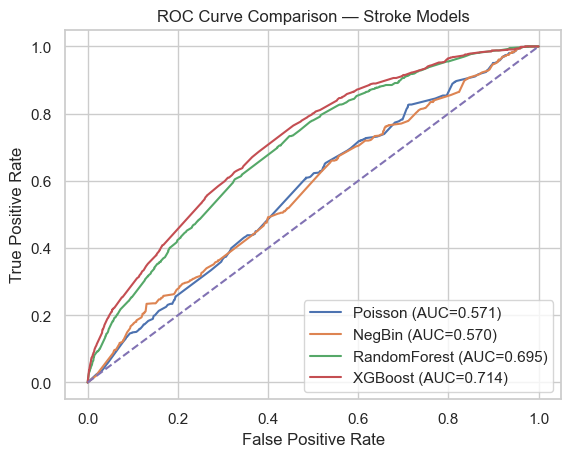

In [28]:
plt.figure()

models_probs = {
    "Poisson": pois_prob,
    "NegBin": nb_prob,
    "RandomForest": rf_prob,
    "XGBoost": xgb_prob
}

for name, prob in models_probs.items():
    fpr, tpr, _ = roc_curve(y, prob)
    auc = roc_auc_score(y, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison — Stroke Models")
plt.legend()

plt.savefig(ROC_DIR / "roc_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

#### Calibration Curves

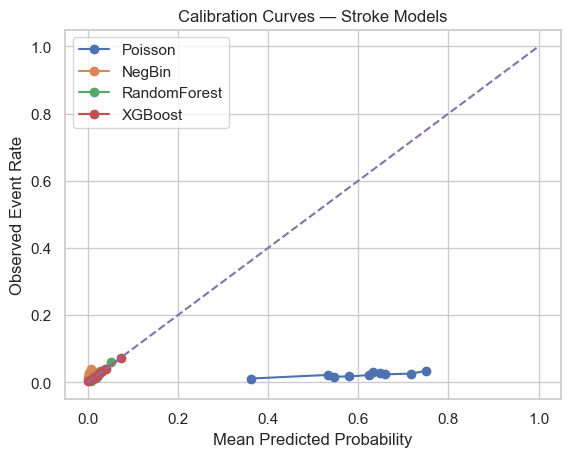

In [29]:
plt.figure()

for name, prob in models_probs.items():
    
    frac_pos, mean_pred = calibration_curve(
        y,
        prob,
        n_bins=10,
        strategy="quantile"
    )

    plt.plot(mean_pred, frac_pos, marker="o", label=name)

plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Observed Event Rate")
plt.title("Calibration Curves — Stroke Models")
plt.legend()

plt.savefig(ROC_DIR / "calibration_curves.png", dpi=300, bbox_inches="tight")
plt.show()

#### Calibration Table Output

In [30]:
cal_tables = []

for name, prob in models_probs.items():
    
    frac_pos, mean_pred = calibration_curve(
        y,
        prob,
        n_bins=10,
        strategy="quantile"
    )
    
    tmp = pd.DataFrame({
        "model": name,
        "predicted": mean_pred,
        "observed": frac_pos
    })
    
    cal_tables.append(tmp)

cal_df = pd.concat(cal_tables)

cal_df.to_csv(ROC_DIR / "calibration_table.csv", index=False)

cal_df.head()

,model,predicted,observed
0,Poisson,0.362255,0.011518
1,Poisson,0.533692,0.022154
2,Poisson,0.545565,0.017167
3,Poisson,0.580527,0.017501
4,Poisson,0.625011,0.022018


#### Brier Score (Calibration Metric)

In [31]:
from sklearn.metrics import brier_score_loss

for name, prob in models_probs.items():
    print(name, "Brier:", brier_score_loss(y, prob))

Poisson Brier: 0.37191368225063076
NegBin Brier: 0.02323763385594337
RandomForest Brier: 0.022587688704012523
XGBoost Brier: 0.022395302119850764
